# TP : Export ONNX, benchmark et quantization

Ce notebook guide les étapes :
- Entraîner un petit CNN sur MNIST (PyTorch)
- Exporter le modèle en ONNX
- Comparer latence (batch sizes 1,8,32,128) entre le modèle PyTorch et ONNX Runtime (CPU)
- Comparer les prédictions (soft outputs) / accuracy
- Quantifier le modèle ONNX (8-bit dynamique) et répéter les benchmarks

Les cellules d'installation vérifient/installs les dépendances nécessaires.

In [23]:
import sys
print('Python', sys.version)


Python 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]


In [24]:
# 2) Import des bibliothèques principales
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import onnx
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType
from tqdm import tqdm
print('torch', torch.__version__, 'onnx', onnx.__version__, 'onnxruntime', ort.__version__)


torch 2.7.1+cu118 onnx 1.19.1 onnxruntime 1.23.1


In [25]:
# 3) Préparer les jeux de données (MNIST) et définir le modèle + entraînement
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

data_dir = 'data_mnist'
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=transform)
# Réduire le train
train_subset = Subset(train_dataset, range(10000))
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)
print('Train size:', len(train_subset), 'Test size:', len(test_dataset))

# Définition du petit CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # Après deux conv (k=3,s=1) et un maxpool(2): entrée 28x28 -> conv->26x26 -> conv->24x24 -> pool->12x12
        self.fc1 = nn.Linear(32*12*12, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu') # Juste pour benchmark
model = SmallCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Fonctions d'entraînement / évaluation

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    return running_loss / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            probs = F.softmax(out, dim=1)
            all_probs.append(probs.cpu().numpy())
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total, np.vstack(all_probs)

# bon j'ai mis 2 epoques par flemme...
epochs = 2
for ep in range(epochs):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    acc, _ = evaluate(model, test_loader, device)
    print(f'Epoch {ep+1}/{epochs} loss={loss:.4f} test_acc={acc:.4f}')

# Sauvegarde du modèle PyTorch
os.makedirs('models', exist_ok=True)

Train size: 10000 Test size: 10000
Epoch 1/2 loss=0.5347 test_acc=0.9337
Epoch 1/2 loss=0.5347 test_acc=0.9337
Epoch 2/2 loss=0.1483 test_acc=0.9607
Epoch 2/2 loss=0.1483 test_acc=0.9607


In [26]:
# 4) Exporter le modèle en ONNX
model.eval()

dummy = torch.randn(1,1,28,28, device=device)
onnx_path = 'models/mnist_smallcnn.onnx'
torch.onnx.export(model, dummy, onnx_path, opset_version=13, input_names=['input'], output_names=['output'], dynamic_axes={'input':{0:'batch'}, 'output':{0:'batch'}})
print('Exported to', onnx_path)
# Vérifier le modèle ONNX
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# Création de la session ONNX Runtime
sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
print('ONNX session providers:', sess.get_providers())

def onnx_predict(sess, X_batch):
    inputs = {sess.get_inputs()[0].name: X_batch.astype(np.float32)}
    out = sess.run(None, inputs)[0]
    return out

# Benchmarks
from torch.utils.data import DataLoader

def benchmark_pytorch(model, loader, device, n_warmup=5):
    model.eval()
    times = []
    with torch.no_grad():
        for i, (X,y) in enumerate(loader):
            X = X.to(device)
            if i < n_warmup:
                _ = model(X)
                continue
            t0 = time.time()
            _ = model(X)
            times.append(time.time()-t0)
    return np.mean(times), np.std(times)


def benchmark_onnx(sess, dataloader, n_warmup=5):
    times = []
    for i, (X,y) in enumerate(dataloader):
        X_np = X.numpy()
        if i < n_warmup:
            _ = onnx_predict(sess, X_np)
            continue
        t0 = time.time()
        _ = onnx_predict(sess, X_np)
        times.append(time.time()-t0)
    return np.mean(times), np.std(times)

batch_sizes = [1,8,32,128]
results = {'pytorch':{}, 'onnx':{}}
for bs in batch_sizes:
    loader_bs = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)
    mean_t, std_t = benchmark_pytorch(model, loader_bs, device)
    results['pytorch'][bs] = (mean_t, std_t)
    print(f'PyTorch bs={bs}: mean={mean_t:.6f}s std={std_t:.6f}s')

for bs in batch_sizes:
    loader_bs = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)
    mean_t, std_t = benchmark_onnx(sess, loader_bs)
    results['onnx'][bs] = (mean_t, std_t)
    print(f'ONNX bs={bs}: mean={mean_t:.6f}s std={std_t:.6f}s')

# Accuracy comparison
acc_pt, probs_pt = evaluate(model, test_loader, device)
print('PyTorch test acc:', acc_pt)

all_preds = []
all_labels = []
for X,y in DataLoader(test_dataset, batch_size=256):
    out = onnx_predict(sess, X.numpy())
    preds = np.argmax(out, axis=1)
    all_preds.append(preds)
    all_labels.append(y.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
acc_onnx = (all_preds == all_labels).mean()
print('ONNX test acc:', acc_onnx)

# Soft predictions comparison on a few examples
X_sample = []
y_sample = []
for i, (X,y) in enumerate(DataLoader(test_dataset, batch_size=1)):
    X_sample.append(X.numpy())
    y_sample.append(y.item())
    if i>=9:
        break
X_sample = np.vstack(X_sample)
with torch.no_grad():
    pt_out = F.softmax(model(torch.from_numpy(X_sample).to(device)), dim=1).cpu().numpy()
onnx_out = onnx_predict(sess, X_sample)
for i in range(10):
    print(i, 'label', y_sample[i], 'pt_pred', np.argmax(pt_out[i]), 'onnx_pred', np.argmax(onnx_out[i]))
    print(' pt_softmax[:5]', np.round(pt_out[i,:5],3), 'onnx_softmax[:5]', np.round(onnx_out[i,:5],3))


Exported to models/mnist_smallcnn.onnx
ONNX session providers: ['CPUExecutionProvider']
PyTorch bs=1: mean=0.000508s std=0.000181s
PyTorch bs=1: mean=0.000508s std=0.000181s
PyTorch bs=8: mean=0.001287s std=0.000177s
PyTorch bs=8: mean=0.001287s std=0.000177s
PyTorch bs=32: mean=0.002205s std=0.000741s
PyTorch bs=32: mean=0.002205s std=0.000741s
PyTorch bs=128: mean=0.005954s std=0.000569s
PyTorch bs=128: mean=0.005954s std=0.000569s
ONNX bs=1: mean=0.000077s std=0.000019s
ONNX bs=1: mean=0.000077s std=0.000019s
ONNX bs=8: mean=0.000171s std=0.000039s
ONNX bs=8: mean=0.000171s std=0.000039s
ONNX bs=32: mean=0.000548s std=0.000072s
ONNX bs=32: mean=0.000548s std=0.000072s
ONNX bs=128: mean=0.001629s std=0.000175s
ONNX bs=128: mean=0.001629s std=0.000175s
PyTorch test acc: 0.9607
PyTorch test acc: 0.9607
ONNX test acc: 0.9607
0 label 7 pt_pred 7 onnx_pred 7
 pt_softmax[:5] [0. 0. 0. 0. 0.] onnx_softmax[:5] [-2.141 -2.517  2.681  2.899 -4.616]
1 label 2 pt_pred 2 onnx_pred 2
 pt_softmax[:

In [27]:
# 5) Quantization dynamique et ré-benchmarks
# Certains runtimes n'implémentent pas ConvInteger. Pour éviter l'erreur, on peut quantifier seulement les opérateurs linéaires (Gemm/MatMul).
from onnxruntime.quantization import quantize_dynamic, QuantType

quant_path = 'models/mnist_smallcnn.quant.onnx'
try:
    # Première tentative: quantifier uniquement MatMul/Gemm (safe)
    quantize_dynamic(onnx_path, quant_path, weight_type=QuantType.QInt8, op_types_to_quantize=['Gemm','MatMul'])
    print('Quantized (Gemm/MatMul only) model saved to', quant_path)
except Exception as e:
    print('First quantize attempt failed:', e)
    # Fallback: try default dynamic quantization (may produce ConvInteger nodes)
    try:
        quantize_dynamic(onnx_path, quant_path, weight_type=QuantType.QInt8)
        print('Quantized (default) model saved to', quant_path)
    except Exception as e2:
        print('Fallback quantize also failed:', e2)
        raise

print('Sizes: original', os.path.getsize(onnx_path), 'quantized', os.path.getsize(quant_path))

# Try to create a session for the quantized model and benchmark
try:
    sess_q = ort.InferenceSession(quant_path, providers=['CPUExecutionProvider'])
    for bs in batch_sizes:
        loader_bs = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)
        mean_t, std_t = benchmark_onnx(sess_q, loader_bs)
        print(f'ONNX-quant bs={bs}: mean={mean_t:.6f}s std={std_t:.6f}s')

    # Accuracy for quantized model
    all_preds_q = []
    for X,y in DataLoader(test_dataset, batch_size=256):
        out_q = onnx_predict(sess_q, X.numpy())
        all_preds_q.append(np.argmax(out_q, axis=1))
    all_preds_q = np.concatenate(all_preds_q)
    acc_q = (all_preds_q == all_labels).mean()
    print('ONNX-quant test acc:', acc_q)
except Exception as sess_err:
    print('failed:', sess_err)
    

Quantized (Gemm/MatMul only) model saved to models/mnist_smallcnn.quant.onnx
Sizes: original 2385462 quantized 614231
ONNX-quant bs=1: mean=0.000090s std=0.000286s
ONNX-quant bs=1: mean=0.000090s std=0.000286s
ONNX-quant bs=8: mean=0.000179s std=0.000043s
ONNX-quant bs=8: mean=0.000179s std=0.000043s
ONNX-quant bs=32: mean=0.000445s std=0.000360s
ONNX-quant bs=32: mean=0.000445s std=0.000360s
ONNX-quant bs=128: mean=0.001434s std=0.000546s
ONNX-quant bs=128: mean=0.001434s std=0.000546s
ONNX-quant test acc: 0.9608
ONNX-quant test acc: 0.9608


Faire une fonction quantize(float_value, min_range, max_range, zero = 0) qui transforme un tableau numpy pouvant prendre des valeurs entre min_range et max_range en un tableau de int8.
On utilisera la formule 
quantized=Int(float_value/S)quantized=Int(float_value/S)
où 
S=max−min2b−1S=2b−1max−min avec b le nombre de bit de la représentation visée
Remark : convert the numpy array type using .astype method

In [28]:
import numpy as np

def quantize(float_value, min_range, max_range, zero=0):
    """
    Quantifie un tableau numpy de float en int8
    
    Args:
        float_value: tableau numpy de valeurs flottantes
        min_range: valeur minimale de la plage d'entrée
        max_range: valeur maximale de la plage d'entrée
        zero: point zéro pour la quantification (décalage)
    
    Returns:
        tableau numpy de valeurs int8 quantifiées
    """ 
    # Nombre de bits pour int8
    b = 8
    
    # Calcul du scaling factor
    S = (max_range - min_range) / (2**b - 1)
    
    # Normalisation des valeurs dans [0, max-min]
    normalized = float_value - min_range
    
    # Quantification : division par S et décalage
    quantized = np.round(normalized / S) - 128 - zero
    
    # Clip pour s'assurer qu'on reste dans [-128, 127]
    quantized = np.clip(quantized, -128, 127)
    
    # Conversion en int8
    return quantized.astype(np.int8)

Faire une fonction to_float(uint_values, min_range, max_range) qui calcule l'opération inverse de la quantization de l'exercice précédent

In [29]:
import numpy as np

def to_float(uint_values, min_range, max_range, zero=0):
    """
    Déquantifie un tableau numpy de int8 en valeurs flottantes
    
    Args:
        uint_values: tableau numpy de valeurs int8 quantifiées
        min_range: valeur minimale de la plage de sortie
        max_range: valeur maximale de la plage de sortie
        zero: point zéro utilisé lors de la quantification
    
    Returns:
        tableau numpy de valeurs flottantes déquantifiées
    """
    # Nombre de bits pour int8
    b = 8
    
    # Calcul du scaling factor (même que pour la quantification)
    S = (max_range - min_range) / (2**b - 1)
    
    # Conversion en float pour les calculs
    float_values = uint_values.astype(np.float32)
    
    # Déquantification : opération inverse
    # quantized = (normalized / S) - 128 - zero
    # donc: normalized = (quantized + 128 + zero) * S
    normalized = (float_values + 128 + zero) * S
    
    # Dénormalisation : ajouter min_range
    dequantized = normalized + min_range
    
    return dequantized


SITUATION 1: Valeurs [0, 0.5] quantifiées avec range [0, 1]


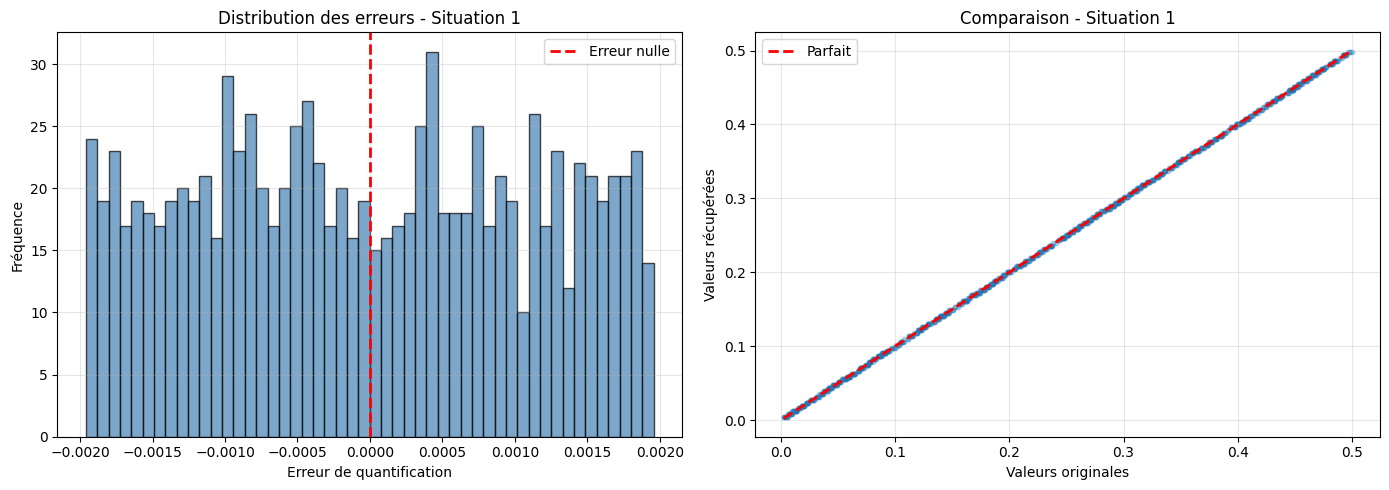

Moyenne: -0.000025, Écart-type: 0.001126
MAE: 0.000979


SITUATION 1 BIS: Valeurs [0, 1] avec plage [0, 1] - Optimal


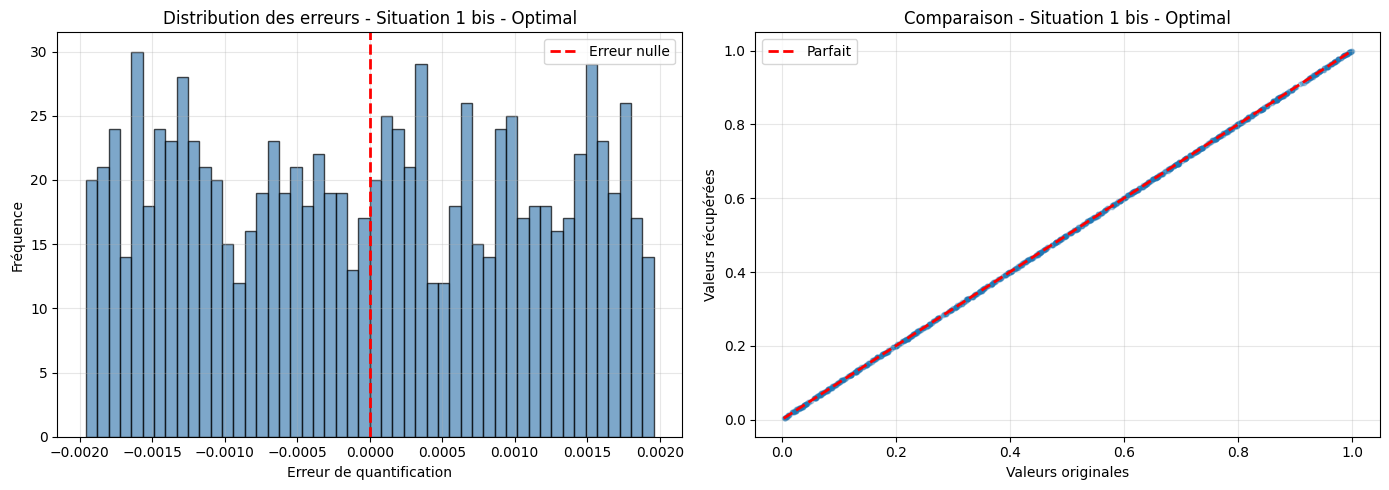

Moyenne: -0.000026, Écart-type: 0.001146
MAE: 0.000997


SITUATION 2: Valeurs [0, 2] quantifiées avec range [0, 1] - CLIPPING!


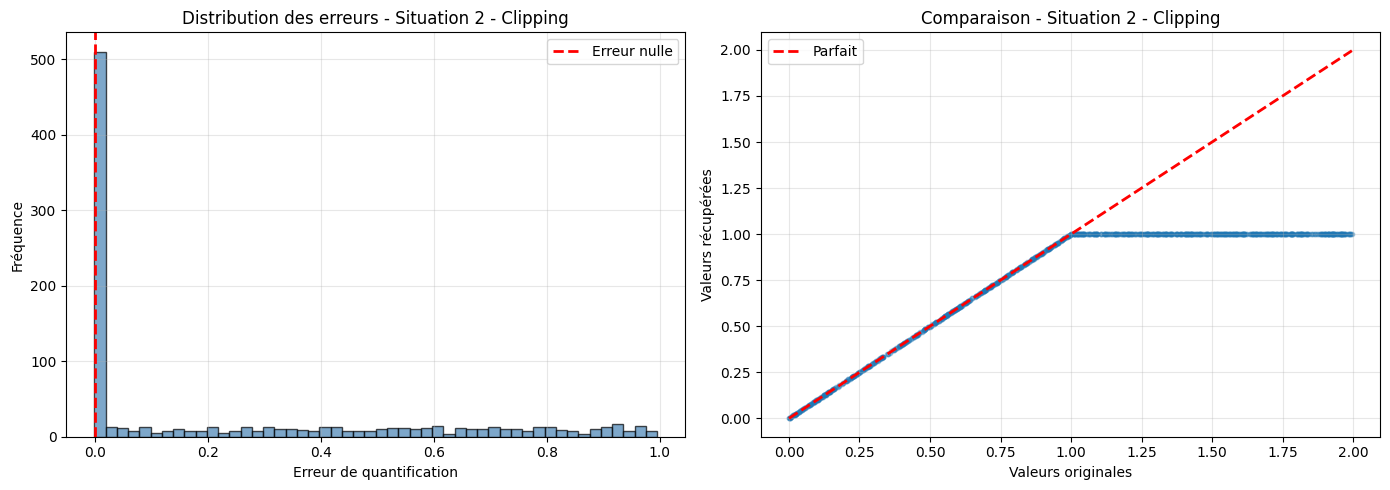

Moyenne: 0.253458, Écart-type: 0.325530
MAE: 0.253998
 Valeurs clippées: 502 sur 1000


SITUATION 3: Valeurs [100, 101] quantifiées avec range [0, 1000]


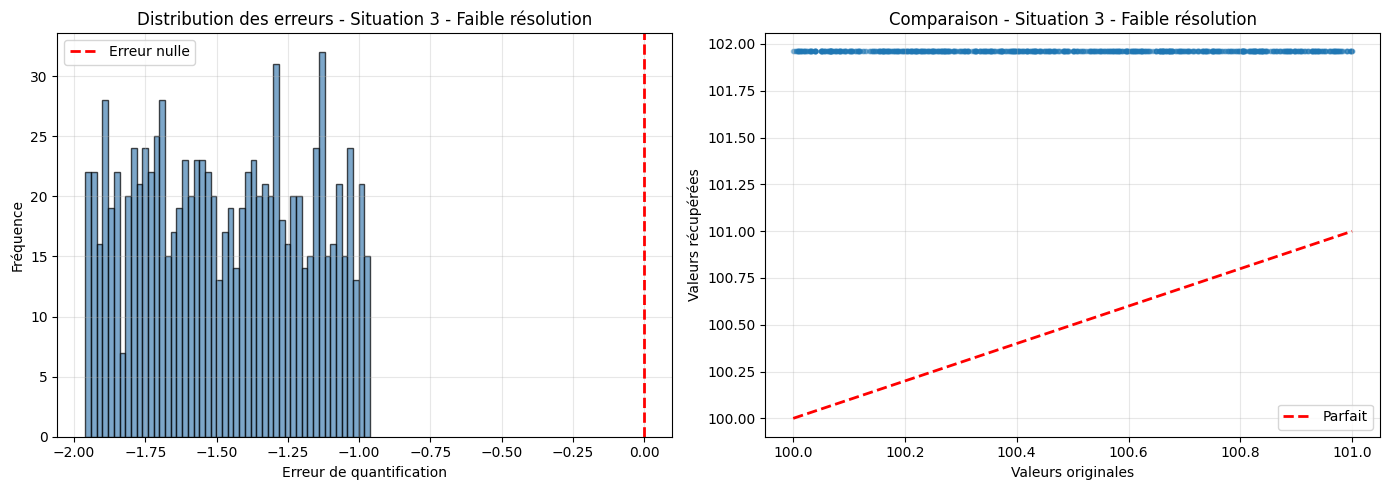

Moyenne: -1.470410, Écart-type: 0.286346
MAE: 1.470410
Résolution: 3.922 pour une plage réelle de 1!


SITUATION 4: Distribution Gaussienne N(0.5, 0.1)


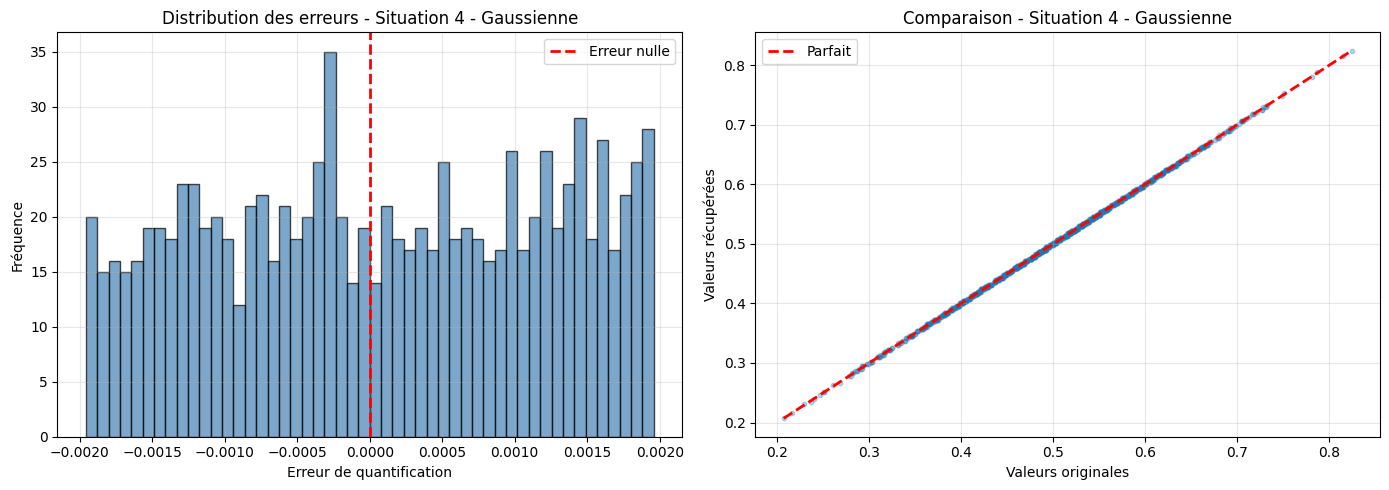

Moyenne: 0.000082, Écart-type: 0.001138
MAE: 0.000991


SITUATION 5: 95% valeurs [0,1] + 5% outliers [5,10]

Avec plage [0, 10] (inclut outliers):


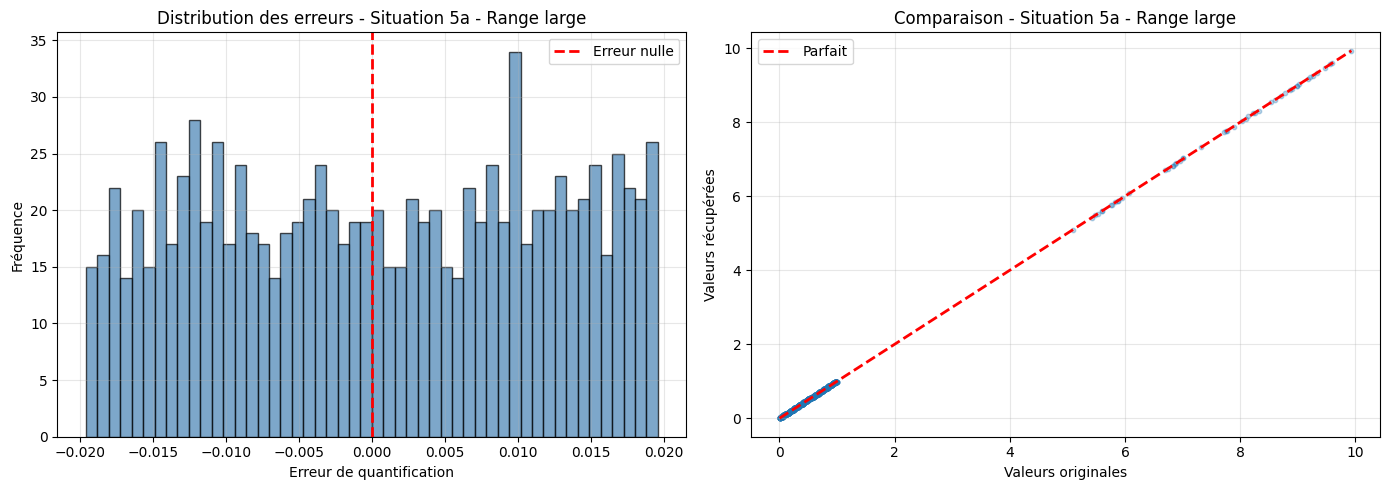

MAE: 0.009989

Avec plage [0, 1] (clippe outliers):


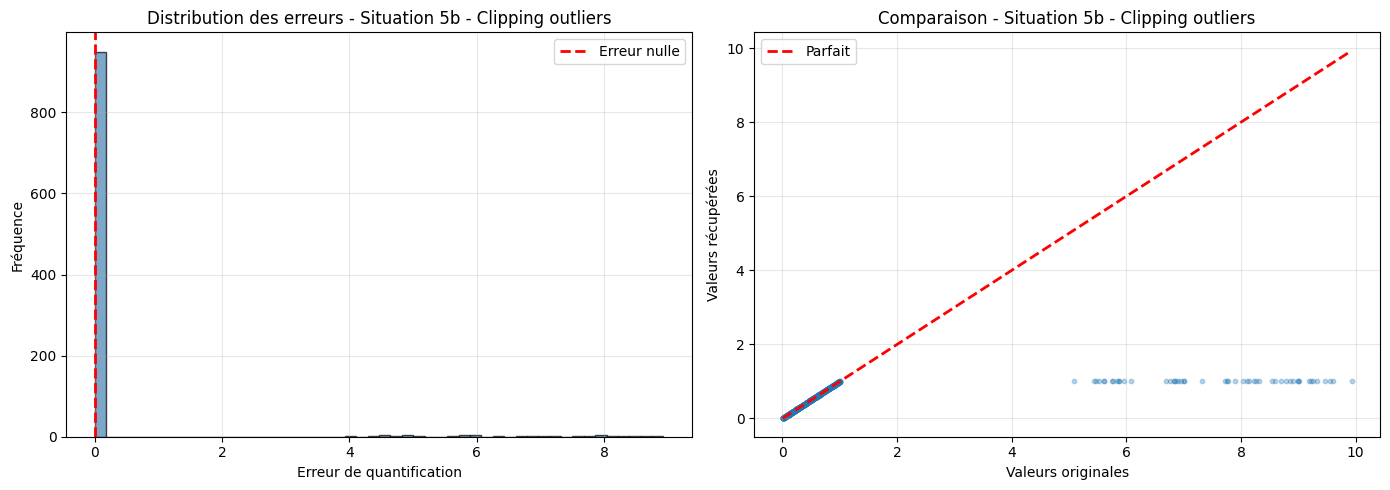

MAE: 0.329061


SITUATION 6: Distribution Beta(2, 5) - Asymétrique


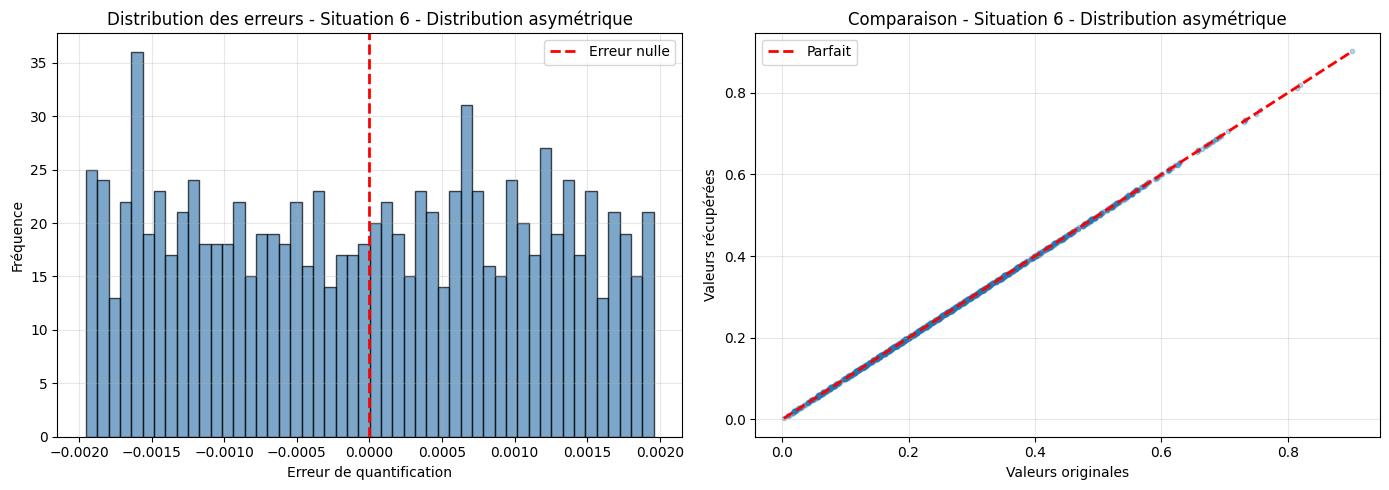

Moyenne: -0.000028, Écart-type: 0.001145
MAE: 0.000998


TABLEAU RÉCAPITULATIF
                  Situation      MAE  Écart-type
S1: Sous-util [0,0.5]→[0,1] 0.000979    0.001126
 S1bis: Optimal [0,1]→[0,1] 0.000997    0.001146
   S2: Clipping [0,2]→[0,1] 0.253998    0.325530
S3: Fine [100,101]→[0,1000] 1.470410    0.286346
             S4: Gaussienne 0.000991    0.001138
       S5a: Outliers [0,10] 0.009989    0.011411
      S5b: Outliers clippés 0.329061    1.463848
       S6: Beta asymétrique 0.000998    0.001145


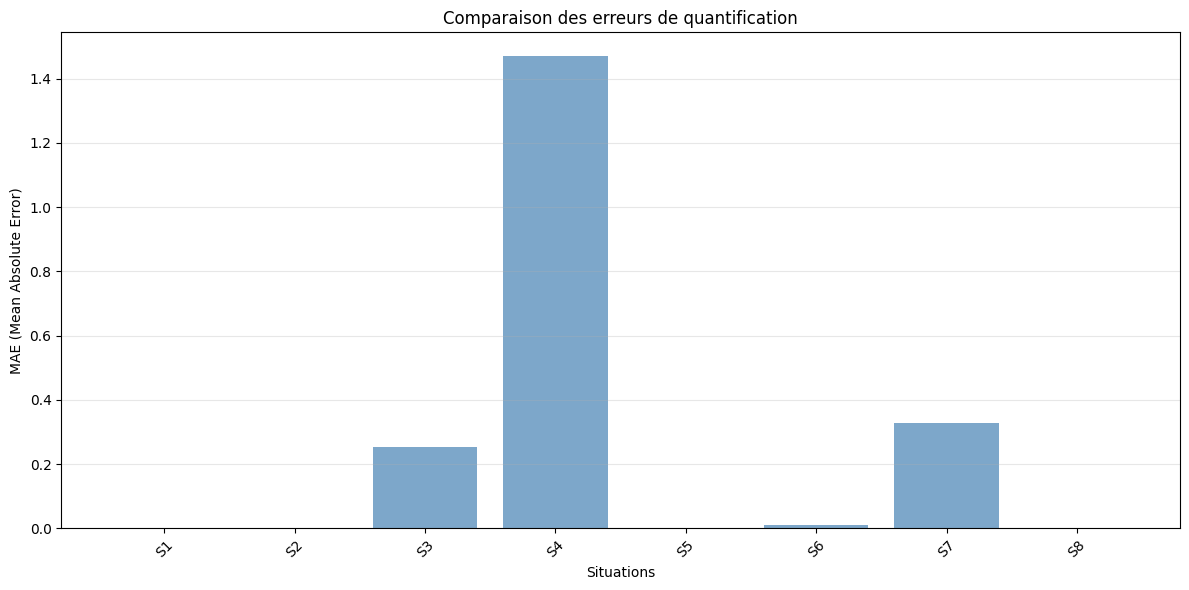

In [35]:
# ============================================================================
# FONCTIONS D'ANALYSE DES ERREURS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

def display_error_histogram(values, min_range, max_range, zero=0, title=""):
    """
    Affiche l'histogramme des erreurs de quantification
    """
    # Quantification puis déquantification
    quantized = quantize(values, min_range, max_range, zero)
    recovered = to_float(quantized, min_range, max_range, zero)
    
    # Calcul des erreurs
    errors = values - recovered
    
    # Création du graphique
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogramme des erreurs
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Erreur de quantification')
    axes[0].set_ylabel('Fréquence')
    axes[0].set_title(f'Distribution des erreurs - {title}')
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Erreur nulle')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot: valeurs originales vs récupérées
    axes[1].scatter(values, recovered, alpha=0.3, s=10)
    axes[1].plot([values.min(), values.max()], [values.min(), values.max()], 
                 'r--', linewidth=2, label='Parfait')
    axes[1].set_xlabel('Valeurs originales')
    axes[1].set_ylabel('Valeurs récupérées')
    axes[1].set_title(f'Comparaison - {title}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def quantization_error_stats(values, min_range, max_range, zero=0):
    """
    Calcule les statistiques des erreurs de quantification
    """
    # Quantification puis déquantification
    quantized = quantize(values, min_range, max_range, zero)
    recovered = to_float(quantized, min_range, max_range, zero)
    
    # Calcul des erreurs
    errors = values - recovered
    
    return {
        'moyenne': np.mean(errors),
        'écart_type': np.std(errors),
        'min': np.min(errors),
        'max': np.max(errors),
        'MAE': np.mean(np.abs(errors))
    }


# ============================================================================
# SITUATION 1: Sous-utilisation de la plage
# ============================================================================
print("\n" + "="*70)
print("SITUATION 1: Valeurs [0, 0.5] quantifiées avec range [0, 1]")
print("="*70)

np.random.seed(42)
values_s1 = np.random.uniform(0, 0.5, 1000)

display_error_histogram(values_s1, 0, 1, title="Situation 1")
stats_s1 = quantization_error_stats(values_s1, 0, 1)
print(f"Moyenne: {stats_s1['moyenne']:.6f}, Écart-type: {stats_s1['écart_type']:.6f}")
print(f"MAE: {stats_s1['MAE']:.6f}\n")


# ============================================================================
# SITUATION 1 BIS: Utilisation optimale
# ============================================================================
print("\n" + "="*70)
print("SITUATION 1 BIS: Valeurs [0, 1] avec plage [0, 1] - Optimal")
print("="*70)

values_s1bis = np.random.uniform(0, 1, 1000)

display_error_histogram(values_s1bis, 0, 1, title="Situation 1 bis - Optimal")
stats_s1bis = quantization_error_stats(values_s1bis, 0, 1)
print(f"Moyenne: {stats_s1bis['moyenne']:.6f}, Écart-type: {stats_s1bis['écart_type']:.6f}")
print(f"MAE: {stats_s1bis['MAE']:.6f}\n")


# ============================================================================
# SITUATION 2: Dépassement de plage (Clipping)
# ============================================================================
print("\n" + "="*70)
print("SITUATION 2: Valeurs [0, 2] quantifiées avec range [0, 1] - CLIPPING!")
print("="*70)

values_s2 = np.random.uniform(0, 2, 1000)

display_error_histogram(values_s2, 0, 1, title="Situation 2 - Clipping")
stats_s2 = quantization_error_stats(values_s2, 0, 1)
print(f"Moyenne: {stats_s2['moyenne']:.6f}, Écart-type: {stats_s2['écart_type']:.6f}")
print(f"MAE: {stats_s2['MAE']:.6f}")
print(f" Valeurs clippées: {np.sum(values_s2 > 1)} sur 1000\n")


# ============================================================================
# SITUATION 3: Plage fine dans grande plage de quantification
# ============================================================================
print("\n" + "="*70)
print("SITUATION 3: Valeurs [100, 101] quantifiées avec range [0, 1000]")
print("="*70)

values_s3 = np.random.uniform(100, 101, 1000)

display_error_histogram(values_s3, 0, 1000, title="Situation 3 - Faible résolution")
stats_s3 = quantization_error_stats(values_s3, 0, 1000)
print(f"Moyenne: {stats_s3['moyenne']:.6f}, Écart-type: {stats_s3['écart_type']:.6f}")
print(f"MAE: {stats_s3['MAE']:.6f}")
print(f"Résolution: {1000/255:.3f} pour une plage réelle de 1!\n")


# ============================================================================
# SITUATION 4 (BONUS): Distribution gaussienne
# ============================================================================
print("\n" + "="*70)
print("SITUATION 4: Distribution Gaussienne N(0.5, 0.1)")
print("="*70)

values_s4 = np.random.normal(0.5, 0.1, 1000)
values_s4 = np.clip(values_s4, 0, 1)

display_error_histogram(values_s4, 0, 1, title="Situation 4 - Gaussienne")
stats_s4 = quantization_error_stats(values_s4, 0, 1)
print(f"Moyenne: {stats_s4['moyenne']:.6f}, Écart-type: {stats_s4['écart_type']:.6f}")
print(f"MAE: {stats_s4['MAE']:.6f}\n")


# ============================================================================
# SITUATION 5 (BONUS): Présence d'outliers
# ============================================================================
print("\n" + "="*70)
print("SITUATION 5: 95% valeurs [0,1] + 5% outliers [5,10]")
print("="*70)

normal_values = np.random.uniform(0, 1, 950)
outliers = np.random.uniform(5, 10, 50)
values_s5 = np.concatenate([normal_values, outliers])
np.random.shuffle(values_s5)

print("\nAvec plage [0, 10] (inclut outliers):")
display_error_histogram(values_s5, 0, 10, title="Situation 5a - Range large")
stats_s5a = quantization_error_stats(values_s5, 0, 10)
print(f"MAE: {stats_s5a['MAE']:.6f}")

print("\nAvec plage [0, 1] (clippe outliers):")
display_error_histogram(values_s5, 0, 1, title="Situation 5b - Clipping outliers")
stats_s5b = quantization_error_stats(values_s5, 0, 1)
print(f"MAE: {stats_s5b['MAE']:.6f}\n")


# ============================================================================
# SITUATION 6 (BONUS): Distribution asymétrique
# ============================================================================
print("\n" + "="*70)
print("SITUATION 6: Distribution Beta(2, 5) - Asymétrique")
print("="*70)

values_s6 = np.random.beta(2, 5, 1000)

display_error_histogram(values_s6, 0, 1, title="Situation 6 - Distribution asymétrique")
stats_s6 = quantization_error_stats(values_s6, 0, 1)
print(f"Moyenne: {stats_s6['moyenne']:.6f}, Écart-type: {stats_s6['écart_type']:.6f}")
print(f"MAE: {stats_s6['MAE']:.6f}\n")


# ============================================================================
# TABLEAU RÉCAPITULATIF
# ============================================================================
print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF")
print("="*70)

import pandas as pd

df = pd.DataFrame({
    'Situation': ['S1: Sous-util [0,0.5]→[0,1]', 
                  'S1bis: Optimal [0,1]→[0,1]',
                  'S2: Clipping [0,2]→[0,1]',
                  'S3: Fine [100,101]→[0,1000]',
                  'S4: Gaussienne',
                  'S5a: Outliers [0,10]',
                  'S5b: Outliers clippés',
                  'S6: Beta asymétrique'],
    'MAE': [stats_s1['MAE'], stats_s1bis['MAE'], stats_s2['MAE'], 
            stats_s3['MAE'], stats_s4['MAE'], stats_s5a['MAE'], 
            stats_s5b['MAE'], stats_s6['MAE']],
    'Écart-type': [stats_s1['écart_type'], stats_s1bis['écart_type'], 
                   stats_s2['écart_type'], stats_s3['écart_type'],
                   stats_s4['écart_type'], stats_s5a['écart_type'],
                   stats_s5b['écart_type'], stats_s6['écart_type']]
})

print(df.to_string(index=False))

# Graphique comparatif
plt.figure(figsize=(12, 6))
x = np.arange(len(df))
plt.bar(x, df['MAE'], alpha=0.7, color='steelblue')
plt.xlabel('Situations')
plt.ylabel('MAE (Mean Absolute Error)')
plt.title('Comparaison des erreurs de quantification')
plt.xticks(x, [f'S{i+1}' for i in range(len(df) )], rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
